In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

### Importing Data

In [101]:
import pandas as pd
df = pd.read_csv('perrin-freres-monthly-champagne.csv')
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


### EDA

In [102]:
df.shape

(107, 2)

In [103]:
df.columns = ['Month', 'Sales']
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [104]:
df.isnull().sum()

Month    1
Sales    2
dtype: int64

In [105]:
df.tail()

,Month,Sales
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [106]:
df.drop([105,106], axis=0, inplace=True)
# df.drop(105, axis=0, inplace=True)

In [107]:
df.shape

(105, 2)

In [108]:
df.dtypes

Month     object
Sales    float64
dtype: object

In [109]:
df['Month'] = pd.to_datetime(df['Month'])

In [110]:
df.dtypes

Month    datetime64[ns]
Sales           float64
dtype: object

In [111]:
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [112]:
df.set_index('Month', inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [113]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sales,105.0,4761.152381,2553.502601,1413.0,3113.0,4217.0,5221.0,13916.0


### Visualizing Sales

<Axes: xlabel='Month'>

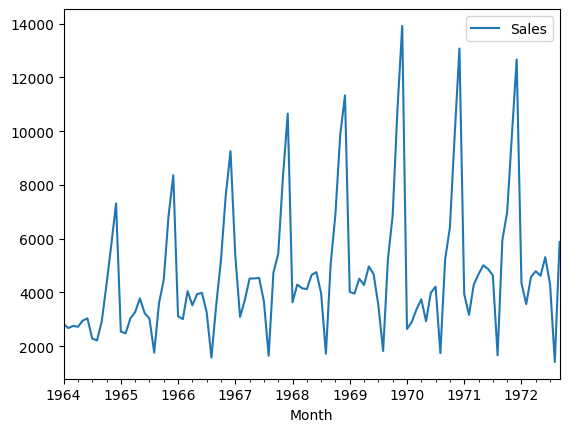

In [114]:
df.plot()

In [115]:
from statsmodels.tsa.stattools import adfuller
adfuller(df['Sales'])

(np.float64(-1.8335930563276195),
 np.float64(0.3639157716602467),
 11,
 93,
 {'1%': np.float64(-3.502704609582561),
  '5%': np.float64(-2.8931578098779522),
  '10%': np.float64(-2.583636712914788)},
 np.float64(1478.4633060594724))

In [116]:
def adfuller_test(sales):
    result = adfuller(sales)
    
    labels = ['ADF test statistics', 'p-value', 'Lags used', 'Number of obs used']
    
    for value, label in zip(result, labels):
        print('{} : {} '.format(label, value))
        
    if result[1]<=0.05:
        print('Strong evidence against null hypothesis, reject the null hypothesis and data is stationary')
    else:
        print('Weak evidence against null hypothesis, accept the null hypothesis and data is not stationary')


In [117]:
adfuller_test(df['Sales'])

ADF test statistics : -1.8335930563276195 
p-value : 0.3639157716602467 
Lags used : 11 
Number of obs used : 93 
Weak evidence against null hypothesis, accept the null hypothesis and data is not stationary


In [118]:
df

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


In [119]:
df['Sales'].shift(1)

Month
1964-01-01       NaN
1964-02-01    2815.0
1964-03-01    2672.0
1964-04-01    2755.0
1964-05-01    2721.0
               ...  
1972-05-01    4788.0
1972-06-01    4618.0
1972-07-01    5312.0
1972-08-01    4298.0
1972-09-01    1413.0
Name: Sales, Length: 105, dtype: float64

In [120]:
df['Sales first diff'] = df['Sales'] - df['Sales'].shift(1)
df.head()

,Sales,Sales first diff
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0


In [121]:
df['Seasonal first diff.'] = df['Sales'] - df['Sales'].shift(12)
df.head()

,Sales,Sales first diff,Seasonal first diff.
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN


In [122]:
adfuller_test(df['Seasonal first diff.'].dropna())

ADF test statistics : -7.626619157213166 
p-value : 2.0605796968136632e-11 
Lags used : 0 
Number of obs used : 92 
Strong evidence against null hypothesis, reject the null hypothesis and data is stationary


<Axes: xlabel='Month'>

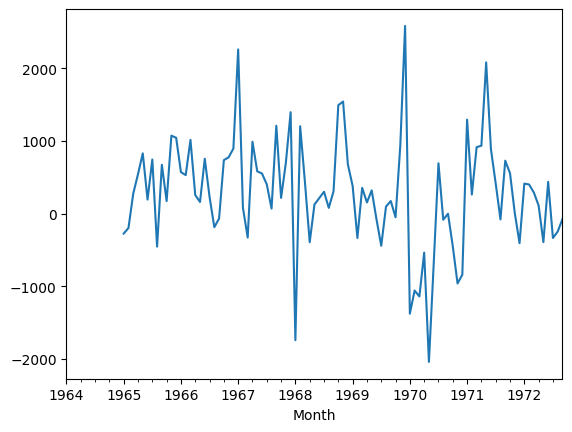

In [123]:
df['Seasonal first diff.'].plot()

### ARIMA

In [124]:
df.head(15)

,Sales,Sales first diff,Seasonal first diff.
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


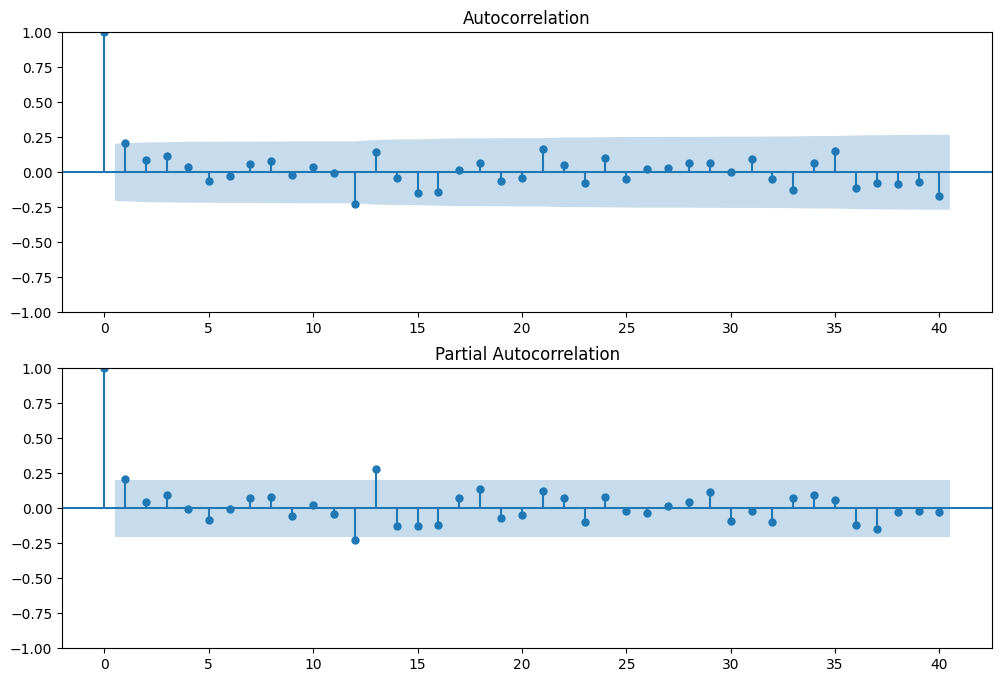

In [125]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal first diff.'].iloc[13:], lags=40, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal first diff.'].iloc[13:], lags=40, ax=ax2)



In [126]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Sales'], order=(1,1,1))

In [127]:
model = model.fit()

In [128]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Fri, 13 Dec 2024   AIC                           1911.627
Time:                        22:18:50   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
df.shape

(105, 3)

In [130]:
df['forecast'] = model.predict(start=90, end=103, dynamic=True)

In [131]:
df.tail(20)

,Sales,Sales first diff,Seasonal first diff.,forecast
Month,,,,
1971-02-01,3162.0,-772.0,263.0,NaN
1971-03-01,4286.0,1124.0,916.0,NaN
1971-04-01,4676.0,390.0,936.0,NaN
1971-05-01,5010.0,334.0,2083.0,NaN
1971-06-01,4874.0,-136.0,888.0,NaN
1971-07-01,4633.0,-241.0,416.0,4977.053418
1971-08-01,1659.0,-2974.0,-79.0,5023.890735
1971-09-01,5951.0,4292.0,730.0,5045.178086
1971-10-01,6981.0,1030.0,557.0,5054.853092


<Axes: xlabel='Month'>

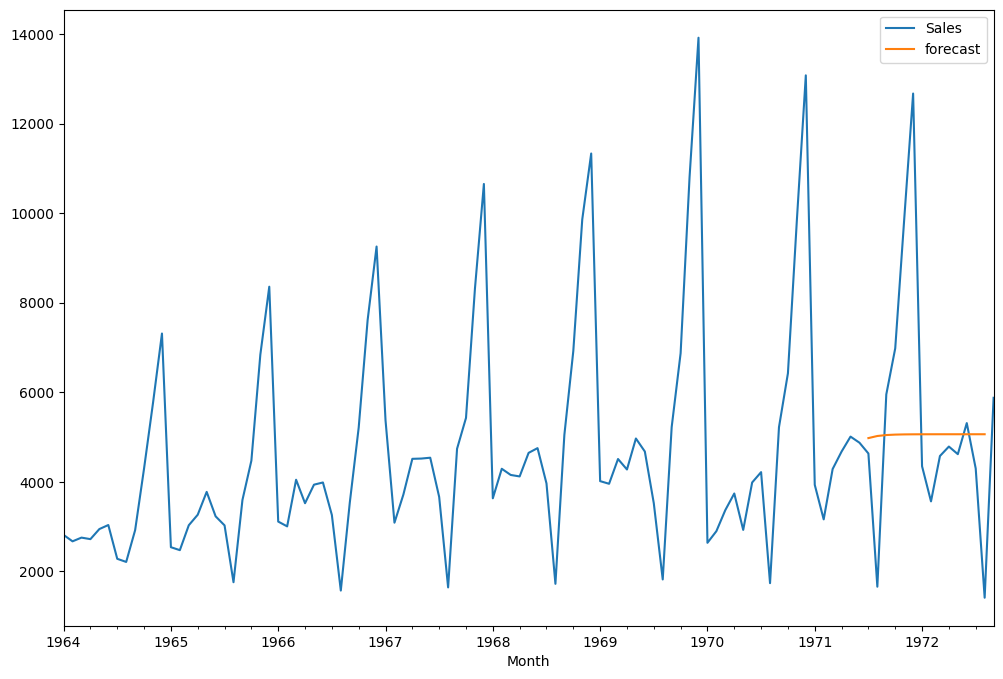

In [132]:
df[['Sales', 'forecast']].plot(figsize=(12,8))

### SARIMAX

In [133]:
model = sm.tsa.statespace.SARIMAX(df['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))

In [134]:
results = model.fit()

In [135]:
df['forecast_SARIMAX'] = results.predict(start=90, end=103, dynamic=True)

In [136]:
df.tail(20)

,Sales,Sales first diff,Seasonal first diff.,forecast,forecast_SARIMAX
Month,,,,,
1971-02-01,3162.0,-772.0,263.0,NaN,NaN
1971-03-01,4286.0,1124.0,916.0,NaN,NaN
1971-04-01,4676.0,390.0,936.0,NaN,NaN
1971-05-01,5010.0,334.0,2083.0,NaN,NaN
1971-06-01,4874.0,-136.0,888.0,NaN,NaN
1971-07-01,4633.0,-241.0,416.0,4977.053418,4437.325223
1971-08-01,1659.0,-2974.0,-79.0,5023.890735,2050.747754
1971-09-01,5951.0,4292.0,730.0,5045.178086,5493.376676
1971-10-01,6981.0,1030.0,557.0,5054.853092,6752.038770


<Axes: xlabel='Month'>

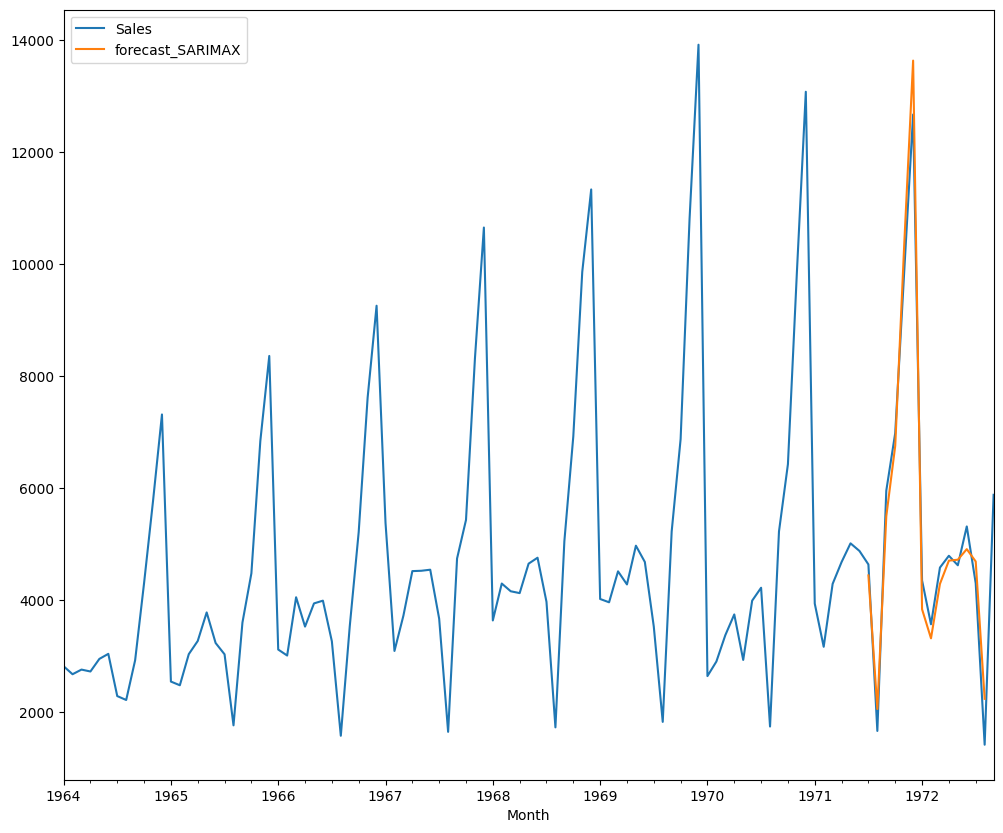

In [137]:
df[['Sales','forecast_SARIMAX']].plot(figsize=(12,10))

In [138]:
future_dates = [df.index[-1] + DateOffset(months=x)for x in range(0,24)]

In [139]:
future_dates[1:]


[Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00')]

In [140]:
future_dataset = pd.DataFrame(index = future_dates[1:], columns = df.columns)

In [141]:
future_dataset.tail()


,Sales,Sales first diff,Seasonal first diff.,forecast,forecast_SARIMAX
1974-04-01,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN,NaN


In [142]:
future_df = pd.concat([df, future_dataset])

In [143]:
future_df.shape

(128, 5)

In [144]:
future_df['forecast_SARIMAX2'] = results.predict(start=104, end=124, dynamic=True)

<Axes: >

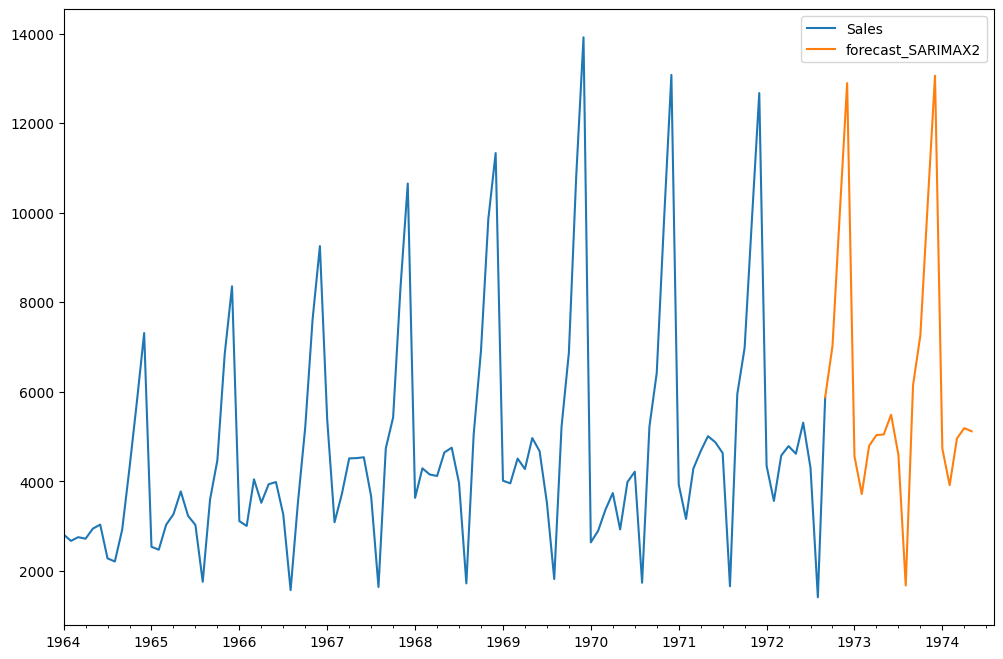

In [145]:
future_df[['Sales', 'forecast_SARIMAX2']].plot(figsize=(12,8))